In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 시각화
import matplotlib.pyplot as plt

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#하이퍼 파라미터 튜닝: 보통 랜덤서치로 대략 파악한 다음 그리드 서치로 미세조정
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# 모델
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 평가도구
from sklearn.metrics import accuracy_score

# 분포
from scipy.stats import uniform, loguniform, randint

In [2]:
preds_labels=pd.read_csv('./preds_labels.csv'); preds_labels2=pd.read_csv('./preds_labels2.csv')

In [4]:
p1=preds_labels['Personality']; p2=preds_labels2['Personality']

In [5]:
sum(p1!=p2)

5

In [255]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# 범주형 변수 변환
for df in [train, test]:
    df['Stage_fear'] = df['Stage_fear'].map({'No': 0, 'Yes': 1})
    df['Drained_after_socializing'] = df['Drained_after_socializing'].map({'No': 0, 'Yes': 1})
    
# 라벨 변환
train['Personality'] = train['Personality'].map({'Introvert': 0, 'Extrovert': 1})

train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0.0,6.0,4.0,0.0,15.0,5.0,1
1,1,1.0,0.0,7.0,3.0,0.0,10.0,8.0,1
2,2,6.0,1.0,1.0,0.0,NaN,3.0,0.0,0
3,3,3.0,0.0,7.0,3.0,0.0,11.0,5.0,1
4,4,1.0,0.0,4.0,4.0,0.0,13.0,NaN,1


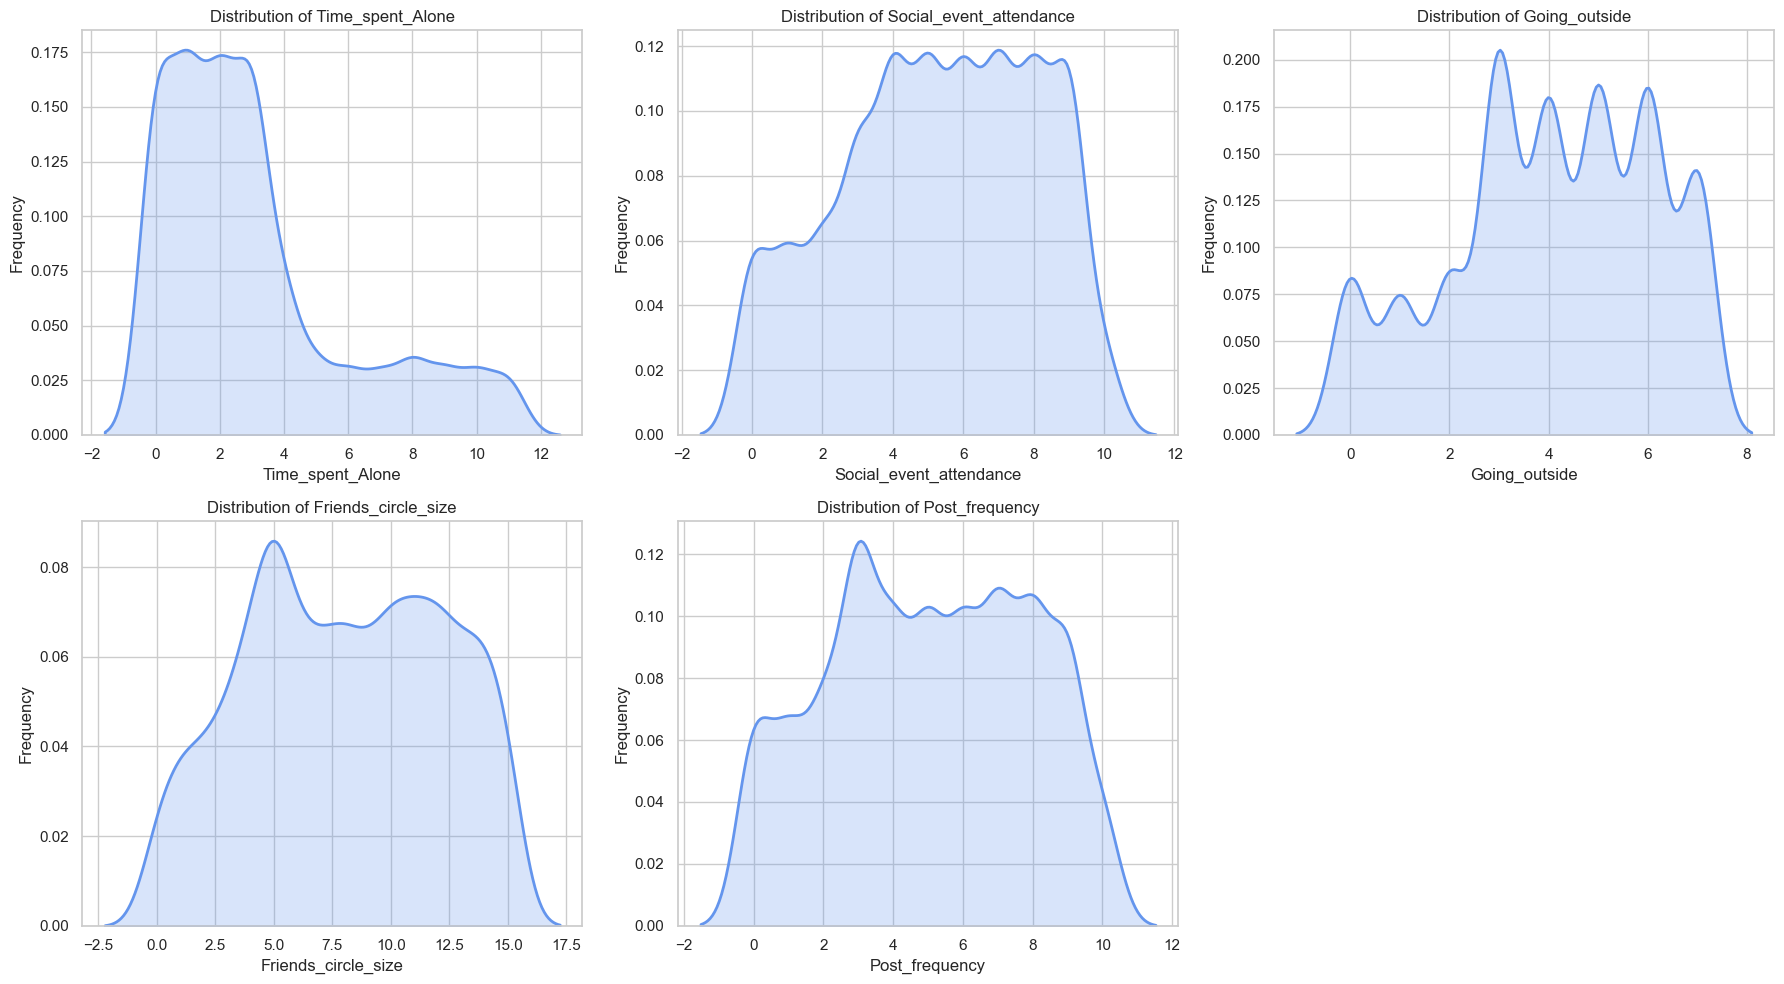

In [267]:
import seaborn as sns

# 수치형 컬럼 리스트
columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
           'Friends_circle_size', 'Post_frequency']

# 시각화 스타일 설정
sns.set(style="whitegrid")

# 서브플롯 설정: 한 줄에 3개씩, 총 5개
plt.figure(figsize=(18, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)  # 2행 3열 중 i번째
    sns.kdeplot(data=df[col].dropna(), fill=True, color='cornflowerblue', linewidth=2)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# 빈 서브플롯 제거 (6번째 칸)
if len(columns) < 6:
    plt.subplot(2, 3, 6)
    plt.axis('off')

plt.tight_layout()
plt.show()
# median, median, knn, knn, median

In [272]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from scipy.stats import skew

def fill_missing_by_manual_strategy(df):
    df_filled = df.copy()
    
    # 전략 기반 분류
    median_columns = [
        'Time_spent_Alone',
        'Social_event_attendance',
        'Post_frequency'
    ]

    knn_or_median_columns = [
        'Going_outside',
        'Friends_circle_size'
    ]

    # 1. 중앙값으로 채울 컬럼
    for col in median_columns:
        df_filled[col] = df[col].fillna(df[col].median())
        print(f"[{col}] → 중앙값(median)으로 채움")

    # 2. KNN 기반 채우기
    # KNNImputer는 여러 컬럼이 함께 있어야 작동하므로 전체에서 knn 대상만 뽑아서 처리
    knn_data = df_filled[knn_or_median_columns]
    knn_imputer = KNNImputer(n_neighbors=5)
    knn_imputed = knn_imputer.fit_transform(knn_data)
    df_filled[knn_or_median_columns] = pd.DataFrame(knn_imputed, columns=knn_or_median_columns)

    for col in knn_or_median_columns:
        print(f"[{col}] → KNN으로 채움")

    return df_filled

In [273]:

df=fill_missing_by_manual_strategy(train)
df.head()

[Time_spent_Alone] → 중앙값(median)으로 채움
[Social_event_attendance] → 중앙값(median)으로 채움
[Post_frequency] → 중앙값(median)으로 채움
[Going_outside] → KNN으로 채움
[Friends_circle_size] → KNN으로 채움


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0.0,6.0,4.0,0.0,15.0,5.0,1
1,1,1.0,0.0,7.0,3.0,0.0,10.0,8.0,1
2,2,6.0,1.0,1.0,0.0,NaN,3.0,0.0,0
3,3,3.0,0.0,7.0,3.0,0.0,11.0,5.0,1
4,4,1.0,0.0,4.0,4.0,0.0,13.0,5.0,1


In [288]:
df['Time_spent_Alone']=11-df['Time_spent_Alone']

In [289]:
df.rename(columns={'Time_spent_Alone':'Time_spent_together'},inplace=True)

In [292]:
col=['Time_spent_together', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
mm=MinMaxScaler()
df[col]=mm.fit_transform(df[col])
df.head()

,id,Time_spent_together,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,1.000000,0.0,0.6,0.571429,0.0,1.000000,0.5,1
1,1,0.909091,0.0,0.7,0.428571,0.0,0.666667,0.8,1
2,2,0.454545,1.0,0.1,0.000000,NaN,0.200000,0.0,0
3,3,0.727273,0.0,0.7,0.428571,0.0,0.733333,0.5,1
4,4,0.909091,0.0,0.4,0.571429,0.0,0.866667,0.5,1


In [293]:
cols = ['Time_spent_together', 'Social_event_attendance', 'Going_outside', 
        'Friends_circle_size', 'Post_frequency']

# 평균 계산 (np.nan 무시하고 row-wise 계산)
df['Social_avg'] = df[cols].sum(axis=1, skipna=True) / df[cols].notna().sum(axis=1)

In [294]:
df.head()

,id,Time_spent_together,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Social_avg
0,0,1.000000,0.0,0.6,0.571429,0.0,1.000000,0.5,1,0.734286
1,1,0.909091,0.0,0.7,0.428571,0.0,0.666667,0.8,1,0.700866
2,2,0.454545,1.0,0.1,0.000000,NaN,0.200000,0.0,0,0.150909
3,3,0.727273,0.0,0.7,0.428571,0.0,0.733333,0.5,1,0.617835
4,4,0.909091,0.0,0.4,0.571429,0.0,0.866667,0.5,1,0.649437


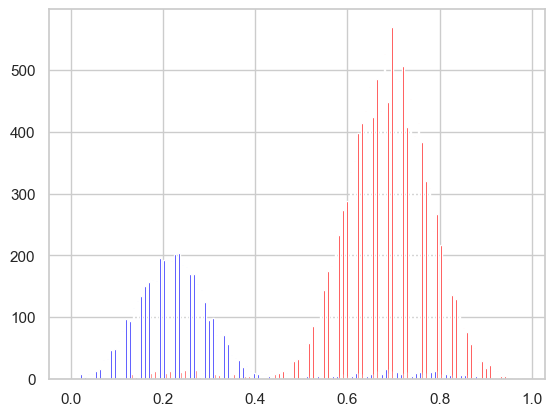

In [333]:
a=[i for i in df.loc[df['Personality']==1,'Social_avg']] #extrovert
b=[i for i in df.loc[df['Personality']==0,'Social_avg']] # introvert
plt.hist((a,b),bins=120,color=['red','blue'])
#plt.hist(b,bins=100,color='blue')
plt.show()

In [328]:
# 0.435기준로로
pd.set_option('display.max_rows', None)
df.loc[df['Personality']==1,'Social_avg'].value_counts().sort_index()

Social_avg
0.026667     1
0.028571     1
0.040000     2
0.044000     1
0.060000     1
0.060087     1
0.064848     1
0.073333     1
0.086753     1
0.088571     1
0.093333     1
0.094286     1
0.096727     1
0.109697     1
0.112727     1
0.115325     1
0.117143     1
0.117143     1
0.120000     1
0.120364     1
0.121991     1
0.122182     1
0.125801     1
0.125801     1
0.129697     1
0.130476     1
0.131515     1
0.136364     1
0.136364     1
0.136571     1
0.137143     1
0.138268     1
0.138528     1
0.140364     1
0.143117     1
0.146061     1
0.147879     1
0.149697     2
0.152727     2
0.153420     1
0.153506     1
0.155325     1
0.156364     1
0.156450     1
0.156727     1
0.157576     1
0.159481     1
0.160173     2
0.161905     1
0.162182     1
0.163810     1
0.164848     2
0.167879     1
0.167965     1
0.169091     1
0.169091     1
0.171688     1
0.171861     1
0.172381     1
0.172814     1
0.173506     1
0.175498     1
0.176450     1
0.178268     1
0.178528     1
0.179048     1

In [336]:
def process_stage_and_drained(df):
    df = df.copy()  # 원본 보호

    # 1. 결측치 채우기 (조건: Social_avg 기준)
    for col in ['Stage_fear', 'Drained_after_socializing']:
        df[col] = df[col].mask(df[col].isna() & (df['Social_avg'] >= 0.435), 1)
        df[col] = df[col].mask(df[col].isna() & (df['Social_avg'] < 0.435), 0)

    # 2. 새로운 조합 컬럼 생성
    def categorize(row):
        if row['Stage_fear'] == row['Drained_after_socializing']:
            return 'both_1' if row['Stage_fear'] == 1 else 'both_0'
        else:
            return 'diff'
    
    df['stage_drained_type'] = df.apply(categorize, axis=1)

    # 3. 원핫 인코딩 (drop_first=True)
    encoded = pd.get_dummies(df['stage_drained_type'], prefix='type', drop_first=True,dtype='int')
    df = pd.concat([df, encoded], axis=1)

    return df

In [338]:
df=process_stage_and_drained(df)
df.head()

,id,Time_spent_together,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Social_avg,stage_drained_type,type_both_1,type_diff
0,0,1.000000,0.0,0.6,0.571429,0.0,1.000000,0.5,1,0.734286,both_0,0,0
1,1,0.909091,0.0,0.7,0.428571,0.0,0.666667,0.8,1,0.700866,both_0,0,0
2,2,0.454545,1.0,0.1,0.000000,0.0,0.200000,0.0,0,0.150909,diff,0,1
3,3,0.727273,0.0,0.7,0.428571,0.0,0.733333,0.5,1,0.617835,both_0,0,0
4,4,0.909091,0.0,0.4,0.571429,0.0,0.866667,0.5,1,0.649437,both_0,0,0


In [339]:
X = df.drop(columns=['id', 'Personality','Stage_fear','Drained_after_socializing','stage_drained_type'])
y = df['Personality']
test = pd.read_csv('./test.csv')
test=fill_missing_by_manual_strategy(test)
test['Time_spent_Alone']=11-test['Time_spent_Alone']
test.rename(columns={'Time_spent_Alone':'Time_spent_together'},inplace=True)
col=['Time_spent_together', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
mm=MinMaxScaler()
test[col]=mm.fit_transform(test[col])
cols = ['Time_spent_together', 'Social_event_attendance', 'Going_outside', 
        'Friends_circle_size', 'Post_frequency']

# 평균 계산 (np.nan 무시하고 row-wise 계산)
test['Social_avg'] = test[cols].sum(axis=1, skipna=True) / test[cols].notna().sum(axis=1)
test['Stage_fear'] = test['Stage_fear'].map({'No': 0, 'Yes': 1})
test['Drained_after_socializing'] = test['Drained_after_socializing'].map({'No': 0, 'Yes': 1})
test=process_stage_and_drained(test)
X_test = test.drop(columns=['id','Stage_fear','Drained_after_socializing','stage_drained_type'])

[Time_spent_Alone] → 중앙값(median)으로 채움
[Social_event_attendance] → 중앙값(median)으로 채움
[Post_frequency] → 중앙값(median)으로 채움
[Going_outside] → KNN으로 채움
[Friends_circle_size] → KNN으로 채움


In [181]:
x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.2)

In [356]:
x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.2)
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),         # 0.01 ~ 0.21
    'subsample': uniform(0.4, 0.6),              # 0.4 ~ 1.0
    'colsample_bytree': uniform(0.4, 0.6),       # 0.4 ~ 1.0
    'reg_alpha': loguniform(1e-5, 0.1),          # L1 규제
    'reg_lambda': uniform(1.0, 1.0),             # 1.0 ~ 2.0
    'min_child_samples': randint(10, 50),
    'num_leaves': randint(20, 150)
}

lgb_model = LGBMClassifier()

random_search3 = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=1,                # 탐색 횟수
    scoring='accuracy',       # 또는 'roc_auc', 'f1', 'neg_log_loss'
    cv=None,
    verbose=1,
    n_jobs=-1
)
random_search3.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 10961, number of negative: 3858
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.739659 -> initscore=1.044195
[LightGBM] [Info] Start training from score 1.044195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=1, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021598EBA5A0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002159909C1D0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_froz...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021598EBB530>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021598EB9AC0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021599206E10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002159905D7F0>},
                   scoring='accuracy', verbose=1)

In [357]:
random_search3.score(X,y),random_search3.score(x_train,y_train),random_search3.score(x_val,y_val)

(0.969822932412006, 0.9695660975774344, 0.9708502024291498)

In [358]:
preds3 = random_search3.predict(X_test)
preds_labels3 = ['Extrovert' if x == 1 else 'Introvert' for x in preds3]
p3=pd.Series(preds_labels3)

In [359]:
sum(p1!=p3), sum(p2!=p3)

(9, 14)

In [360]:
submission = pd.DataFrame({'id': test['id'], 'Personality': preds_labels3})
submission.to_csv('./submission_lgbm914.csv', index=False)